# Introduction


- Some features are categorical: ['waterfront', 'view','condition','grade']


In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline


In [2]:
# load dataset from .csv, 
# split into X and y and 
# remove columns I don't want or need ['id','date', 'zipcode'] 

dataset = pd.read_csv('kc_house_data.csv')
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
dataset.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### Data Exploration:
Here we shall explore the data and create two list - catagorical variables and less_related varaibles

In [4]:
dataset.shape

(21613, 21)

In [5]:
less_related = []
categorical = []



In [6]:
less_related.append('id')

#### lets analyze the date little more

In [7]:
tempdf = dataset.loc[:,["date","yr_built"]]
tempdf.head()

,date,yr_built
0,20141013T000000,1955
1,20141209T000000,1951
2,20150225T000000,1933
3,20141209T000000,1965
4,20150218T000000,1987


In [8]:
##The above looks like date has significate in price. Price of the house on the date
## and year Build is the when its build so, year of the house = year(date) - yr_built
dataset['date'] = dataset['date'].str.slice(0, 4) ## taking first 4 char

In [9]:
dataset['date'][:4]

0    2014
1    2014
2    2015
3    2014
Name: date, dtype: object

In [10]:
print('Year built Nulls:',dataset['yr_built'].isnull().sum())
print('Date Nulls: ',dataset['date'].isnull().sum())

Year built Nulls: 0
Date Nulls:  0


In [11]:
## let me create another variable named house_age and 
dataset['house_age'] = dataset.apply(lambda x: int(x['date']) - int(x['yr_built']), axis=1)
dataset['house_age'][:2]

0    59
1    63
Name: house_age, dtype: int64

In [12]:
##Lets drop date now
less_related.append("date")
less_related.append('yr_built')

### Let us see the distinct water front, view ,condition, garden values

In [13]:
dataset['waterfront'].value_counts()

0    21450
1      163
Name: waterfront, dtype: int64

In [14]:
avg_price_1 =dataset[dataset['waterfront']==0]['price'].mean()
avg_price_2 =dataset[dataset['waterfront']==1]['price'].mean()
print('Average price of the houses where water front Not Present :',avg_price_1)
print('Average price of the houses where water front Present ',avg_price_2)

Average price of the houses where water front Not Present : 531563.5998135199
Average price of the houses where water front Present  1661876.0245398772


In [15]:
##Lets see number of bedrooms where waterfront
avg_bedroom_1 =dataset[dataset['waterfront']==0]['bedrooms'].mean()
avg_bedroom_2 =dataset[dataset['waterfront']==1]['bedrooms'].mean()
print('Average Bedroom of the houses where water front Not Present :',avg_bedroom_1)
print('Average Bedroom of the houses where water front Present ',avg_bedroom_2)

Average Bedroom of the houses where water front Not Present : 3.3713752913752915
Average Bedroom of the houses where water front Present  3.3006134969325154


In [16]:
## So houses near water front has more price, so assuming it has significance
categorical.append("waterfront")

In [17]:
dataset['view'].value_counts()

0    19489
2      963
3      510
1      332
4      319
Name: view, dtype: int64

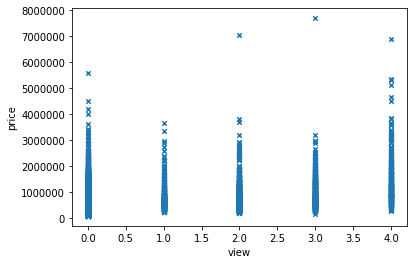

In [18]:
dataset.plot('view', 'price', kind = 'scatter', marker = 'x');

In [19]:
##Above shows view does not have much impact of price, hence we will drop this
## Lets add this to drop list
less_related.append('view')

In [20]:
dataset['condition'].value_counts()

3    14031
4     5679
5     1701
2      172
1       30
Name: condition, dtype: int64

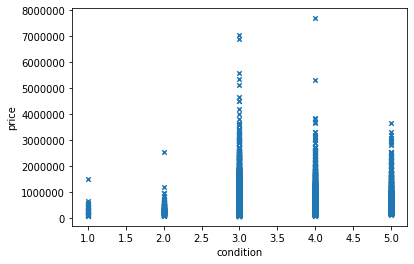

In [21]:
dataset.plot('condition', 'price', kind = 'scatter', marker = 'x');

In [22]:
## Condition has huge impact but it's value are 1,2,3 has to convert it to a dummy varaibles
categorical.append('condition')

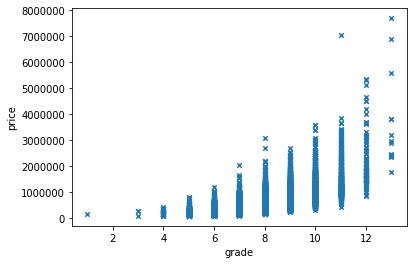

In [23]:
## Lets treat grade
dataset.plot('grade', 'price', kind = 'scatter', marker = 'x');

In [24]:
## Above shows higher grade has higher price 
##more or less linear
categorical.append('grade')

In [25]:
## Converting year renovated to renovated. 0 if not renovated 1 if renovated
dataset['renovated'] = dataset.apply(lambda row: 1 if int(row['yr_renovated'])>0 
                                     else 0,axis=1)

In [26]:
dataset['renovated'].value_counts()

0    20699
1      914
Name: renovated, dtype: int64

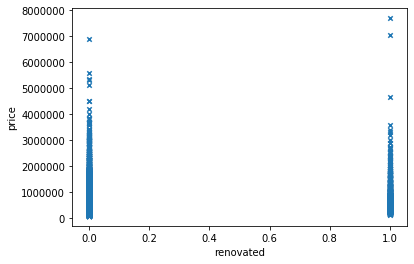

In [27]:
dataset.plot('renovated', 'price', kind = 'scatter', marker = 'x');

In [29]:
##Renovated is not much related
less_related.append('renovated')
less_related.append('yr_renovated')

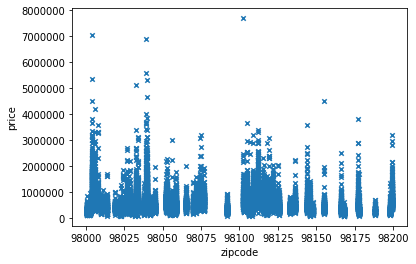

In [28]:
## Zip code are plenty, Loks like price is not much dependent on the zip code
dataset.plot('zipcode', 'price', kind = 'scatter', marker = 'x');

In [30]:
##Zip code has high corellation with the price, But there are plenty of zipcode
print('The of different zip codes are :',len(dataset['zipcode'].unique()))

The of different zip codes are : 70


### Zip Code:
Since there are 70 zip codes we can't make 70 cat vaiables, let us see price 4 quartiles and distribute the zip codes in 4 category based price quantile

In [34]:
price_quantiles = dataset['price'].quantile([0.25,0.50,0.75,1])

In [38]:
print(price_quantiles)

0.25     321950.0
0.50     450000.0
0.75     645000.0
1.00    7700000.0
Name: price, dtype: float64


In [36]:
dataset['price'].max()

7700000.0

In [49]:
def zip_category(price):
    
    if price<price_quantiles[0.25]:
        return 1
    elif price<price_quantiles[0.50]:
        return 2
    elif price<price_quantiles[0.75]:
        return 3
    else:
        return 4
print(zip_category(600000))
    

3


In [50]:
dataset['price_category_zip'] = dataset['price'].apply(zip_category)

In [51]:
dataset.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'house_age', 'renovated',
       'price_category_zip'],
      dtype='object')

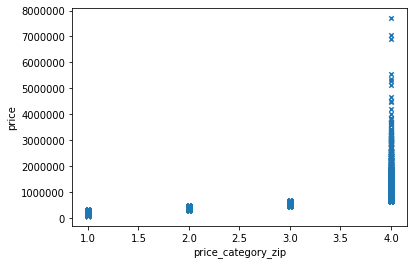

In [52]:
## Lets see the distribution now
dataset.plot('price_category_zip', 'price', kind = 'scatter', marker = 'x');

In [53]:
##So Append price_category_zip in categorical and drop zip
categorical.append('price_category_zip')
less_related.append('zipcode')

In [54]:
## As we added long and lat we shall add long and lat also in less_related
less_related.append('long')
less_related.append('lat')

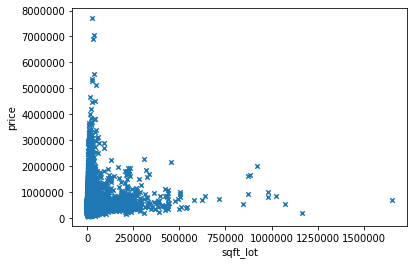

In [55]:
##Validate 'sqft_lot'
dataset.plot('sqft_lot', 'price', kind = 'scatter', marker = 'x');

In [56]:
## Above shows the sqft_lot has significance, as less sqft_lot price is higher

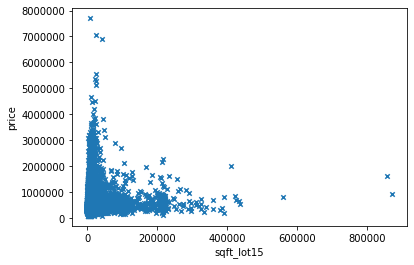

In [57]:
##Lets validate sqft_lot15
dataset.plot('sqft_lot15', 'price', kind = 'scatter', marker = 'x');

In [58]:
## sqft_lot15 aslo looks like have good significance

In [59]:
dataset.shape

(21613, 24)

In [60]:
print('To be removed variables are :',less_related)
print('Categorical Variables are :',categorical)
#['waterfront', 'view','condition','grade']

To be removed variables are : ['id', 'date', 'yr_built', 'view', 'renovated', 'yr_renovated', 'zipcode', 'long', 'lat']
Categorical Variables are : ['waterfront', 'condition', 'grade', 'price_category_zip']


In [61]:
##Lets drop the less important varaibles
df = dataset.copy()
print('Before removing number of features',df.shape[1])
df = df.drop(less_related,axis=1)
print('After removing number of features',df.shape[1])

Before removing number of features 24
After removing number of features 15


In [62]:
y = df[['price']]
X = df.drop(['price'],axis=1)
print('Y shape:',y.shape)
print('X shape:',X.shape)

Y shape: (21613, 1)
X shape: (21613, 14)


In [63]:
## Now add the dummy variables in X
X_dummies =  pd.get_dummies(X, columns = categorical, prefix = categorical, drop_first=True)
X_dummies.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_living15,sqft_lot15,house_age,...,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,price_category_zip_2,price_category_zip_3,price_category_zip_4
0,3,1.00,1180,5650,1.0,1180,0,1340,5650,59,...,1,0,0,0,0,0,0,0,0,0
1,3,2.25,2570,7242,2.0,2170,400,1690,7639,63,...,1,0,0,0,0,0,0,0,1,0
2,2,1.00,770,10000,1.0,770,0,2720,8062,82,...,0,0,0,0,0,0,0,0,0,0
3,4,3.00,1960,5000,1.0,1050,910,1360,5000,49,...,1,0,0,0,0,0,0,0,1,0
4,3,2.00,1680,8080,1.0,1680,0,1800,7503,28,...,0,1,0,0,0,0,0,0,1,0


In [64]:
X_dummies.shape

(21613, 29)

# Function to run my model:


In [65]:
from sklearn.metrics import accuracy_score
def run_model(model,X_input,y_input):
    x_train, x_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.2)
    model.fit(x_train, y_train)
    train_score = model.score(x_train,y_train)
    train_preds = model.predict(x_train)
    train_rmse = np.sqrt(mean_squared_error(y_train,train_preds))
    print("Train :: R^2 = " + "%.2f"%train_score + " :: RMSE = " + "%.2f"%train_rmse)
    test_score = model.score(x_test,y_test)
    test_preds = model.predict(x_test)
    test_rmse = np.sqrt(mean_squared_error(y_test,test_preds))
    print("Test  :: R^2 = " + "%.2f"%test_score  + " :: RMSE = " + "%.2f"%test_rmse)
    return (y_train,train_preds,y_test,test_preds)


In [66]:
print("Model Outpit for Linear Regression")
lr = LinearRegression()
y_train,y_train_hat,y_test,y_test_pred =  run_model(lr,X_dummies,y)


Model Outpit for Linear Regression
Train :: R^2 = 0.77 :: RMSE = 176591.14
Test  :: R^2 = 0.75 :: RMSE = 179878.24


### Trying Polinomial Grid Search CV

In [67]:
pipe = Pipeline([('poly', PolynomialFeatures()),('lr', LinearRegression())])
params = {'poly__degree' : [2,3]}
grid = GridSearchCV(pipe, param_grid=params, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(X_dummies, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('lr',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None, param_grid={'poly__degree': [2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='ne

In [68]:
grid.best_params_

{'poly__degree': 2}

In [69]:
grid.cv_results_

{'mean_fit_time': array([ 0.5302907 , 47.75291538]),
 'std_fit_time': array([0.09482795, 0.99949119]),
 'mean_score_time': array([0.01533117, 0.14379487]),
 'std_score_time': array([0.00316445, 0.00895498]),
 'param_poly__degree': masked_array(data=[2, 3],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'poly__degree': 2}, {'poly__degree': 3}],
 'split0_test_score': array([ -169772.76258936, -1305247.77598021]),
 'split1_test_score': array([ -542808.83630258, -2140733.56477782]),
 'split2_test_score': array([-147986.87890189, -598644.70696862]),
 'split3_test_score': array([-174574.5597405 , -446468.32014006]),
 'split4_test_score': array([-166608.09959313, -969083.51601487]),
 'mean_test_score': array([ -240350.22742549, -1092035.57677631]),
 'std_test_score': array([151497.66774027, 603412.91905688]),
 'rank_test_score': array([1, 2], dtype=int32)}

In [70]:
print("Test :: RMSE = " + "%.2f"%grid.cv_results_['mean_test_score'][0])

Test :: RMSE = -240350.23
